In [2]:
import sys
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import fnmatch
import librosa
import librosa.display
import scipy.signal
import matplotlib.pyplot as plt
sys.path.append("/home/wgar/PRockClassify/")

In [3]:
from torch.utils.data import DataLoader
from data.dataloader import *
from global_constants import *
from tqdm import tqdm

from multiprocessing.pool import Pool as ThreadPool

In [4]:
opt = {"root_prog": "/media/wgar/New Volume1/dataset/cap6610sp19_project/Progressive Rock Songs/",
       "root_nonprog": "/media/wgar/New Volume1/dataset/cap6610sp19_project/0_Not_prog/",
       "num_workers": 4,
       "batch_size": 2}
windows = {'hamming': scipy.signal.hamming, 'hann': scipy.signal.hann, 'blackman': scipy.signal.blackman,
'bartlett': scipy.signal.bartlett}
window_size = 0.02  # Window size for spectrogram in seconds

In [5]:
class MusicDataset(Dataset):
    def __init__(self, opt, mode, type=MFCC, debug=False, quiet=False, pre_cache=False):
        super(MusicDataset, self).__init__()
        self.mode = mode  # to load train/val/test data
        self.type = type
        self.quiet = quiet
        # load the json file which contains information about the dataset
        self.dataset_manifest = []
        self.dataset_cache = {}
        for mp3_root in (opt["root_prog"], opt["root_nonprog"]):
            for root, dirs, filenames in os.walk(mp3_root):
                for ffn in fnmatch.filter(filenames, '*.mp3'):
                    full_path = os.path.join(root, ffn)
                    if mp3_root == opt["root_prog"]:
                        target = 1.0
                    else:
                        target = 0.0
                        
                    self.dataset_manifest.append((full_path, target))
        
        if debug:
            np.random.shuffle(self.dataset_manifest)
            self.dataset_manifest = self.dataset_manifest[:32]
        
        self.n = len(self.dataset_manifest)
        
        # Some params borrowed from DeepSpeech project : https://github.com/SeanNaren/deepspeech.pytorch/blob/master/data/data_loader.py
        # Sample rate 44100 for music (voice is 16000)
        self.disk_sample_rate = 44100
        self.sample_rate = self.disk_sample_rate
        self.window_size = 0.02  # Window size for spectrogram in seconds
        self.window_stride = 0.01  # Window stride for spectrogram in seconds
        self.n_fft = int(self.sample_rate * self.window_size)
        self.window = windows['hamming']  # Window type for spectrogram generation
        self.normalize = True
        
        num_train = int(train_split * self.n)
        num_val = int(val_split * self.n)
        self.splits = {  # TODO(WG)
            'train': list(np.arange(0, num_train)),
            'val': list(np.arange(num_train, num_train + num_val)),
            'test': list(np.arange(num_train + num_val, self.n))
        }

        if not quiet:
            dlogger.debug('number of train songs:\t{}'.format(len(self.splits['train'])))
            dlogger.debug('number of val songs:\t{}'.format(len(self.splits['val'])))
            dlogger.debug('number of test songs:\t{}'.format(len(self.splits['test'])))
            # self.n_frame_steps = opt['n_frame_steps']

        if pre_cache:
            dlogger.info("Pre-caching STFT features...")
            jobs = []
            for ix in self.splits[self.mode]:
                full_path, target = self.dataset_manifest[ix]
                jobs.append((ix, full_path))
                
            pool = ThreadPool(opt["num_workers"])
            res = pool.imap_unordered(self.cache_feat_job, jobs)
            for ix, spect in tqdm(res):
                self.dataset_cache[ix] = spect
                
        dlogger.info("Finished initializing dataloader.")

    def __getitem__(self, ix):
        """This function returns a tuple that is further passed to collate_fn
        """
        ix = ix % len(self.splits[self.mode])
        full_path, target = self.dataset_manifest[ix]
        if not self.quiet: dlogger.debug('Load ix={}'.format(ix))
        # sample_id = 'sample_{}'.format(self.splits[self.mode][ix])
        # sample_query = self.h5file.root[sample_id]
        
        data = {}
        if self.dataset_cache.get(ix) is not None:
            data['x'] = self.dataset_cache[ix]
        elif self.type == 'log':
            # x = sample_query.raw[0]
            x = self.load_audio(full_path)
            spect = self.extract_feature(x)
                
            data['x'] = spect
            self.dataset_cache[ix] = spect
        else:
            # Caching raw array won't be viable
            x = self.load_audio(full_path)
            data['x'] = Variable(torch.from_numpy(x).type(torch.FloatTensor))

        data['gt'] = Variable(torch.tensor(float(target)))
        data['sample_id'] = ix

        return data

    def __len__(self):
        return len(self.splits[self.mode])
    
    def load_audio(self, full_path):
        x, _ = librosa.load(full_path, sr=self.sample_rate, mono=True, offset=10.0, duration=120.0)
        return x
    
    def extract_feature(self, x):
        num_sec = float(len(x)) / self.disk_sample_rate
        num_min = int(np.ceil(float(num_sec) / 60.))
        # Taking the whole music sample runs out of memory (10 minute ~= 6GB RAM).
        # Instead, concat some small 10 second windows. Take 10 seconds @ 16khz from every minute of audio
        xp = np.zeros((disk_sample_rate * num_min * 60))
        xp[:len(x)] = x
        xp = xp.reshape(num_min, disk_sample_rate * 60)
        # sub-sample minute-wise. 10 seconds per minute, from end to avoid intro
        xp = xp[:,-disk_sample_rate * 10:]
        xp = np.concatenate(xp, axis=0)
        x = xp

        # Short-time Fourier transform (STFT) spectrogram (complex valued)
        window_length = self.n_fft
        hop_length = int(self.sample_rate * self.window_stride)
        n_fft = self.n_fft

        D = librosa.stft(x, n_fft=n_fft, hop_length=hop_length,
                         win_length=window_length, window=self.window)

        # Separate a complex-valued spectrogram D into its magnitude (S) and phase (P) components, so that D = S * P.
        spect, phase = librosa.magphase(D) 

        # S = log(S + 1)
        # Return the natural logarithm of one plus the input array, element-wise.
        spect = np.log1p(spect)
        spect = torch.FloatTensor(spect)
        if self.normalize:
            mean = spect.mean()
            std = spect.std()
            spect.add_(-mean)
            spect.div_(std)

        return spect
    
    def cache_feat_job(self, meta):
        ix, fpath = meta
        if not self.quiet: dlogger.debug('Load ix={}'.format(ix))
        x = self.load_audio(fpath)
        spect = self.extract_feature(x)
        return ix, spect
    
def _collate_fn(batch):
    """
    Modified version of DS2 collate 
    :param batch: The mini batched data from dataset __getitem__
    :return: 
    """
    def func(p):
        return p['x'].size(1)

    batch = sorted(batch, key=lambda sample: sample['x'].size(1), reverse=True)
    longest_sample = max(batch, key=func)['x']
    freq_size = longest_sample.size(0)
    minibatch_size = len(batch)
    max_seqlength = longest_sample.size(1)
    # Pseudo-image shape - BxCxDxT: Batch x Channel (1 channel) x Freq bins x Time bins
    inputs = torch.zeros(minibatch_size, 1, freq_size, max_seqlength)
    input_percentages = torch.FloatTensor(minibatch_size)
    targets = []
    for x in range(minibatch_size):
        sample = batch[x]
        tensor = sample['x']
        target = sample['gt']
        seq_length = tensor.size(1)
        inputs[x][0].narrow(1, 0, seq_length).copy_(tensor)
        input_percentages[x] = seq_length / float(max_seqlength)
        targets.append(target)
    targets = torch.IntTensor(targets)
    return inputs, targets, input_percentages


class MusicDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Data loader for MusicDataset to replace collate_fn
        """
        super(MusicDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn
        

In [6]:
dataset_stft = MusicDataset(opt, 'train', type='log', debug=True, quiet=True, pre_cache=True)
# dataset_raw = MusicDataset(opt, 'train', type=RAW, quiet=True, debug=True)

  INFO     | <ipython-input-5-46ce6336dea3> | Pre-caching STFT features...
16it [00:13,  1.18it/s]
  INFO     | <ipython-input-5-46ce6336dea3> | Finished initializing dataloader.


In [7]:
loader = MusicDataLoader(dataset_stft, batch_size=opt["batch_size"], shuffle=True, num_workers=4)

In [31]:
dataset_stft.__getitem__(1)

  DEBUG    | <ipython-input-24-a3329355cdff> | Load ix=1


{'gt': tensor(1.),
 'sample_id': 1,
 'x': tensor([[ 5.7277,  1.1772,  3.6036,  ...,  2.3029,  3.0958,  5.5577],
         [ 2.7661,  4.6879,  5.1478,  ...,  6.2709,  6.5344,  6.4719],
         [ 3.9484,  4.8367,  4.7933,  ...,  6.3494,  6.3004,  6.2362],
         ...,
         [-0.4422, -0.4611, -0.4609,  ..., -0.4641, -0.4390, -0.4647],
         [-0.4426, -0.4599, -0.4600,  ..., -0.4642, -0.4390, -0.4630],
         [-0.4425, -0.4605, -0.4605,  ..., -0.4642, -0.4390, -0.4591]])}

In [6]:
d = dataset_raw.__getitem__(0)
print(d['x'].shape)
# print(dataset_stft.__getitem__(1)['x'].shape)
# print(dataset_stft.__getitem__(2)['x'].shape)
# print(dataset_stft.__getitem__(3)['x'].shape)

torch.Size([5292000])


In [7]:
x0 = d['x']
num_sec = float(len(x0)) / disk_sample_rate
num_min = int(np.ceil(float(num_sec) / 60.))
print("dsr:\t{}".format(disk_sample_rate))
print("Num seconds:\t{}".format(num_sec))
print("Num minutes:\t{}".format(num_min))

dsr:	44100
Num seconds:	120.0
Num minutes:	2


In [8]:
# pad minute-wise
xp = np.zeros((disk_sample_rate * num_min * 60))
xp[:len(x0)] = x0
xp = xp.reshape(num_min, disk_sample_rate * 60)
print(xp.shape)
# sub-sample minute-wise. 10 seconds per minute, from end to avoid intro
xp = xp[:,-disk_sample_rate * 10:]
print(xp.shape)
xp = np.concatenate(xp, axis=0)
print(xp.shape)

(2, 2646000)
(2, 441000)
(882000,)


In [8]:
for data in loader:
    inputs, targets, input_percentages = data
    print(inputs.shape)
    print(targets.shape)
    print(targets.data)
    break

torch.Size([2, 1, 442, 2001])
torch.Size([2])
tensor([0, 0], dtype=torch.int32)


In [21]:
ds = dataset_stft.__getitem__(0)
print(ds['x'].shape)

torch.Size([442, 2001])


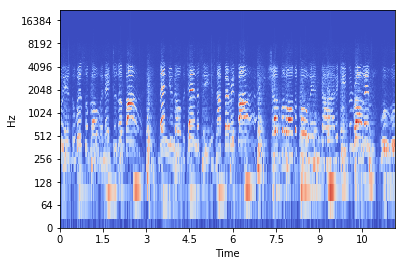

In [34]:
librosa.display.specshow(ds['x'][:, :1000].numpy(), sr=sample_rate, x_axis='time', y_axis='log')

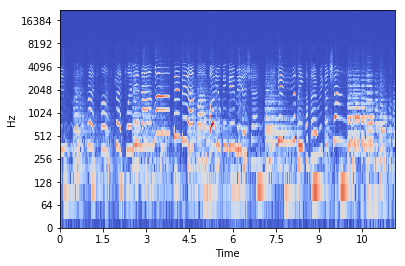

In [35]:
librosa.display.specshow(ds['x'][:, 1000:].numpy(), sr=sample_rate, x_axis='time', y_axis='log')

In [9]:
class MaskConv(nn.Module):
    def __init__(self, seq_module):
        """
        Adds padding to the output of the module based on the given lengths. This is to ensure that the
        results of the model do not change when batch sizes change during inference.
        Input needs to be in the shape of (BxCxDxT)
        :param seq_module: The sequential module containing the conv stack.
        """
        super(MaskConv, self).__init__()
        self.seq_module = seq_module

    def forward(self, x, lengths):
        """
        :param x: The input of size BxCxDxT
        :param lengths: The actual length of each sequence in the batch
        :return: Masked output from the module
        """
        for module in self.seq_module:
            x = module(x)
            mask = torch.ByteTensor(x.size()).fill_(0)
            if x.is_cuda:
                mask = mask.cuda()
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths

In [10]:
conv = MaskConv(nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
                nn.BatchNorm2d(32),
                nn.Hardtanh(0, 20, inplace=True),
                nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
                nn.BatchNorm2d(32),
                nn.Hardtanh(0, 20, inplace=True)
                ))

# Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
rnn_input_size = int(math.floor((dataset_stft.sample_rate * window_size) / 2) + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)

rnn_input_size *= 32

In [39]:
dataset_stft.sample_rate

44100

In [57]:
# Debug batch BxCxDxT
dx = ds['x']
b = np.zeros((opt['batch_size'], 1) + dx.shape)
b[:, 0, :, :] = dx
b = torch.from_numpy(b).float()
b.shape

torch.Size([2, 1, 221, 2005])

In [11]:
# Real batch
for data in loader:
    inputs, targets, input_percentages = data
    input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
    print(inputs.shape)
    print(targets.shape)
    print(targets.data)
    break

torch.Size([2, 1, 442, 2001])
torch.Size([2])
tensor([0, 0], dtype=torch.int32)


In [12]:
conv = conv.cuda()
inputs = inputs.cuda()

In [13]:
def get_seq_lens(input_length):
    """
    Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
    containing the size sequences that will be output by the network.
    :param input_length: 1D Tensor
    :return: 1D Tensor scaled by model
    """
    seq_len = input_length
    for m in conv.modules():
        if type(m) == nn.modules.conv.Conv2d:
            seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) / m.stride[1] + 1)
    return seq_len.int()

In [14]:
lengths = input_sizes.cpu().int()
output_lengths = get_seq_lens(lengths)
cb = conv(inputs, output_lengths)
cbx, cb_lengths = cb
cbx.shape

torch.Size([2, 32, 111, 1001])

In [41]:
cbnp = cb.detach().cpu().numpy()

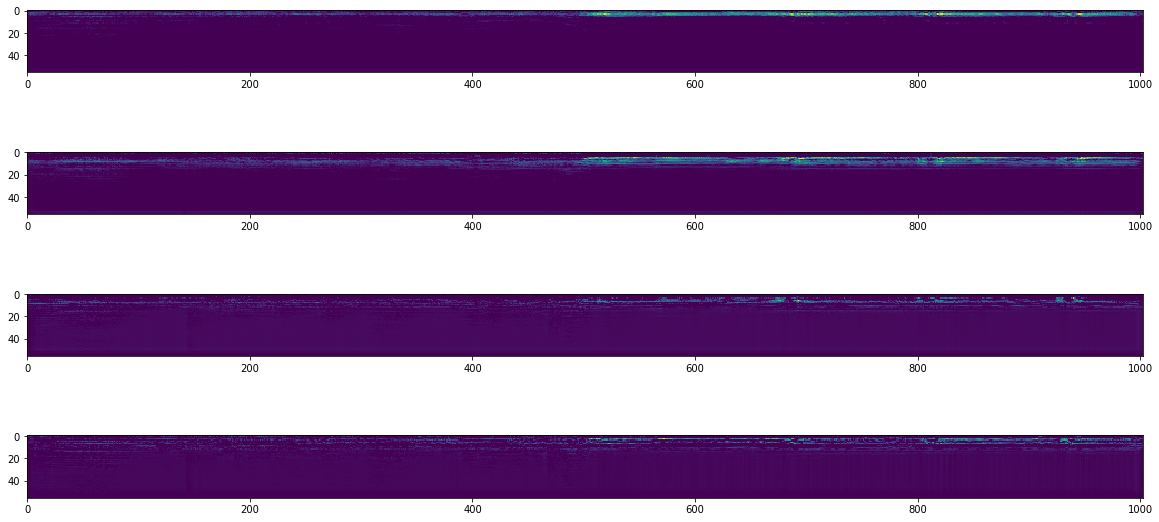

In [55]:
# Across 4 conv channels with random weights
fig = plt.figure()
ax = fig.add_subplot(411)
ax.imshow(cbnp[0, 0])
ax = fig.add_subplot(412)
ax.imshow(cbnp[0, 10])
ax = fig.add_subplot(413)
ax.imshow(cbnp[0, 20])
ax = fig.add_subplot(414)
ax.imshow(cbnp[0, 30])
fig.set_size_inches(20, 10)
plt.show()

In [15]:
rnn_enc = nn.RNN(input_size=rnn_input_size, hidden_size=800, bidirectional=False)
rnn_dec = nn.RNN(input_size=800, hidden_size=100, bidirectional=False)

In [16]:
rnn_enc = rnn_enc.cuda()

In [17]:
rnn_dec = rnn_dec.cuda()

In [30]:
print("Final needed size: ", rnn_input_size)
print("Original size: ", cbx.shape)
x = cbx
sizes = x.size()
x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # collapse feature dim
print(x.size())
x = x.transpose(1, 2).transpose(0, 1).contiguous()  # TxNxH
print(x.size())

Final needed size:  3552
Original size:  torch.Size([2, 32, 111, 1001])
torch.Size([2, 3552, 1001])
torch.Size([1001, 2, 3552])


In [31]:
x = nn.utils.rnn.pack_padded_sequence(x, output_lengths)
print(x[0].shape, x[1].shape)
x, h = rnn_enc(x)
print(x[0].shape, x[1].shape)
x, _ = nn.utils.rnn.pad_packed_sequence(x)
print(x[0].shape, x[1].shape)

torch.Size([2002, 3552]) torch.Size([1001])
torch.Size([2002, 800]) torch.Size([1001])
torch.Size([2, 800]) torch.Size([2, 800])


In [23]:
x.shape  # Latent space x

torch.Size([1001, 2, 800])

In [32]:
x = nn.utils.rnn.pack_padded_sequence(x, output_lengths)
print(x[0].shape, x[1].shape)
x, h = rnn_dec(x)
print(x[0].shape, x[1].shape)
x, _ = nn.utils.rnn.pad_packed_sequence(x)
print(x[0].shape, x[1].shape)

torch.Size([2002, 800]) torch.Size([1001])
torch.Size([2002, 100]) torch.Size([1001])
torch.Size([2, 100]) torch.Size([2, 100])


In [56]:
x.shape  # Log-regr space

torch.Size([1001, 2, 100])

In [57]:
fc = nn.Linear(100, 2, bias=False)
fc = fc.cuda()

In [58]:
wx = fc(x)
wx = wx.transpose(0, 1)
wx.shape

torch.Size([2, 1001, 2])

In [64]:
sm = F.softmax(wx, dim=-1)
sm.shape

torch.Size([2, 1001, 2])

In [60]:
# dim=1 are convolved time steps, prog or not prog at each (could be incorrect)
sm_bar = sm.mean(dim=1)

In [61]:
print(sm_bar[0, :].sum())
print(sm_bar[1, :].sum())

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)
tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


In [62]:
sm_bar

tensor([[0.5031, 0.4969],
        [0.4778, 0.5222]], device='cuda:0', grad_fn=<MeanBackward0>)